In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import requests 
from bs4 import BeautifulSoup 
import time
from googlesearch import search 
from mechanize import Browser 
import umap

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

stop_words = stopwords.words('english')
unwanted_chars = ['.',':',',',"n't","'ve",'http','https','co']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df_tweets=pd.read_csv('works_so_far.csv')
df_IN = df_tweets.query("user_country == 'IN' & compound_sentiment < -0.05")
df_IN.columns

Index(['Unnamed: 0', 'id', 'user_name', 'user_location', 'user_description',
       'user_created', 'user_followers', 'user_friends', 'user_favourites',
       'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets',
       'favorites', 'is_retweet', 'user_city', 'user_country', 'city_latitude',
       'city_longitude', 'text_words', 'neg_sentiment', 'pos_sentiment',
       'neu_sentiment', 'compound_sentiment'],
      dtype='object')

In [17]:
def getTopics(df, features_num = 1000, threshold = 0.2, topic_num = 10):
    # removing everything except alphabets
    df['clean_text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
    
    # tokenization
    tweets = df['clean_text'].apply(lambda x: x.split())

    # remove stop-words & unwanted chars and URL components
    tweets = tweets.apply(lambda x: [item for item in x if item not in stop_words])
    tweets = tweets.apply(lambda x: [item for item in x if item not in unwanted_chars])
    
    # de-tokenization
    detokenized_tweets = []
    for i in range(len(df)):
        t = ' '.join(tweets.tolist()[i])
        detokenized_tweets.append(t)
    df['clean_text'] = detokenized_tweets
    
    
    vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= features_num, # keep top 1000 terms 
                             max_df = threshold, # threshold of ignoring super high frequency words
                             smooth_idf=True)
    X = vectorizer.fit_transform(df['clean_text'])
    
    # SVD represent documents and terms in vectors 
    svd_model = TruncatedSVD(n_components = topic_num, algorithm='randomized', n_iter=100, random_state=122)
    svd_model.fit(X)
    
    terms = vectorizer.get_feature_names()
    topics=[]
    for i, comp in enumerate(svd_model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        string = "Topic "+str(i)+": "
        for t in sorted_terms:
            string = string + t[0] + ' '
        print(string)
        topics.append(string)
        
        
    br = Browser()
    i = 0
    meaningful_topics = []
    for query in topics:
        i = i+1
        print("Google search results for the ", i, "-th topic is about:") 
        for url in search(query, tld="com", lang='en',num=2, start=0,stop=2, pause=5.0):
            time.sleep(10)
            # making requests instance 
            reqs = requests.get(url)
            # using the BeaitifulSoup module
            soup = BeautifulSoup(reqs.text, 'html.parser')
            # displaying the title 
            try:
                print(str(soup.find_all('title')[0])[7:-8])
                meaningful_topics.append(str(soup.find_all('title')[0])[7:-8])
            except:
                print("This website does not have a title, the URL is: ", url)
                meaningful_topics.append(str(url))
            
    
    X_topics = svd_model.fit_transform(X)
    embedding = umap.UMAP(n_neighbors=topic_num/2, min_dist=0.02*topic_num, random_state=12).fit_transform(X_topics)
    plt.figure(figsize=(7,5))
    plt.scatter(embedding[:, 0], embedding[:, 1],# c = de_tweets['user_city'],
                s = 5, # size
                edgecolor='none')
    plt.show()
    return meaningful_topics

%%time
df_tweets=pd.read_csv('works_so_far.csv')
df_IN = df_tweets.query("user_country == 'IN'")
topics = getTopics(df_IN, features_num = 1000, threshold = 0.2, topic_num = 10)

In [18]:
topics = getTopics(df_IN, features_num = 1000, threshold = 0.2, topic_num = 10)

<ipython-input-17-5df3cbc993bb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
<ipython-input-17-5df3cbc993bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
<ipython-input-17-5df3cbc993bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = detokenized_tweets


Topic 0: health allergic canada ingredients warned coronavirus india 
Topic 1: india coronavirus allowed covidvaccination tiauqijkr sb sfndmev 
Topic 2: receiving elderly died deaths dzsoua experts fj 
Topic 3: world organization validation granted health authorised basis 
Topic 4: deaths says link vaccination post ivcpzyv jab 
Topic 5: withdraw amp vaccines request india vaccinated dead 
Topic 6: amp approved coronavirus eu anxqm cnb efficacy 
Topic 7: dead getting vaccinated bzyqx note pus vaccines 
Topic 8: death autopsy gjtvdpp pathetic report scarry connection 
Topic 9: developed bear bhakts boycott igtuww zoo astrazeneca 
Google search results for the  1 -th topic is about:
Health Canada warns people allergic to COVID-19 vaccine ingredients as cases surpass 450K - National | Globalnews.ca
Canada warns allergic people against Pfizer Covid-19 vaccine - Times of India
Google search results for the  2 -th topic is about:
Pfizer-BioNTech COVID-19 Vaccine | FDA
COVID-19 Vaccine | Mass.

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function empty>) found for signature:
 
 >>> empty(Tuple(int64, float64), dtype=class(int32))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload of function 'empty': File: numba\core\typing\npydecl.py: Line 504.
    With argument(s): '(Tuple(int64, float64), dtype=class(int32))':[0m
[1m   No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function empty>)[0m
[0m[1mDuring: typing of call at C:\Users\Wuyue\anaconda3\lib\site-packages\umap\utils.py (30)
[0m
[1m
File "..\..\..\..\anaconda3\lib\site-packages\umap\utils.py", line 30:[0m
[1mdef fast_knn_indices(X, n_neighbors):
    <source elided>
    """
[1m    knn_indices = np.empty((X.shape[0], n_neighbors), dtype=np.int32)
[0m    [1m^[0m[0m


In [120]:
import pandas as pd
df_tweets=pd.read_csv('works_so_far.csv')
df_tweets= df_tweets.query("user_city == 'London'")
len(df_tweets)

156

In [157]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

stop_words = stopwords.words('english')
unwanted_chars = ['.',':',',',"n't","'ve",'http','https','co']

# removing everything except alphabets
df_tweets['clean_text'] = df_tweets['text'].str.replace("[^a-zA-Z#]", " ")

# tokenization
tweets = df_tweets['clean_text'].apply(lambda x: x.split())

# remove stop-words & unwanted chars and URL components
tweets = tweets.apply(lambda x: [item for item in x if item not in stop_words])
tweets = tweets.apply(lambda x: [item for item in x if item not in unwanted_chars])

# de-tokenization
detokenized_tweets = []
for i in range(len(df_tweets)):
    t = ' '.join(tweets.tolist()[i])
    detokenized_tweets.append(t)
df_tweets['clean_text'] = detokenized_tweets
df_tweets[['text','clean_text']].head(3)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Wuyue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-157-d1359d0b2068>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets['clean_text'] = df_tweets['text'].str.replace("[^a-zA-Z#]", " ")


,text,clean_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Same folks said daikon paste could treat cytokine storm #PfizerBioNTech xeHhIMg kF
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",While world wrong side history year hopefully biggest vaccination effort ev dlCHrZjkhm
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid Russian vaccine created last years ieYlCKBr P


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000, # keep top 1000 terms 
                             max_df = 0.2, # threshold of ignoring super high frequency words
                             smooth_idf=True)

X = vectorizer.fit_transform(df_tweets['clean_text'])

X.shape # check shape of the document-term matrix

(156, 960)

In [126]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [127]:
terms = vectorizer.get_feature_names()
topics=[]
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    string = "Topic "+str(i)+": "
    for t in sorted_terms:
        string = string + t[0] + ' '
    print(string)
    topics.append(string)
    

Topic 0: vaccines pfizer moderna uk dose pfizervaccine oxfordastrazeneca 
Topic 1: moderna vaccines anegpg different hsy mixed oxfordastrazeneca 
Topic 2: vaccinated americans announces hours trump rollout fzqsmnhoy 
Topic 3: covidvaccine modernavaccine immune wile long aaj audwp 
Topic 4: pfizer uk biontech night em contents gprfye 
Topic 5: pfizervaccine dose second zkwnlikx astrazeneca weeks available 
Topic 6: astrazeneca johnson uk amp news coronavirus nhs 
Topic 7: pfizervaccine today pfizercovidvaccine zkwnlikx astrazeneca chose jydkibpbsd 
Topic 8: uk today vaccination getting news vaccinated week 
Topic 9: johnson amp shot nhs today dose got 
Topic 10: effects good news yesterday week day pfizervaccine 
Topic 11: administered vaccines castle household windsor doctor said 
Topic 12: eu people medicines approved shot regulator yesterday 
Topic 13: vaccination imperialnhs yesterday eu uclh hall far 
Topic 14: grateful patients risk doses healthcare science receive 
Topic 15: just

In [128]:
#!pip install bs4
#!pip install requests
#!pip install beautifulsoup4
#!pip install google
#!pip install mechanize

In [129]:
import requests 
from bs4 import BeautifulSoup 
import time
from googlesearch import search 
from mechanize import Browser 

In [130]:
# to search 
br = Browser()
i = 0
for query in topics:
    i = i+1
    print("Google search results for the ", i, "-th topic is:") 
    for url in search(query, tld="com", lang='en',start=0,stop=2, pause=5.0):
        time.sleep(10)
        # making requests instance 
        reqs = requests.get(url)
        # using the BeaitifulSoup module 
        soup = BeautifulSoup(reqs.text, 'html.parser')
        # displaying the title 
        print(str(soup.find_all('title')[0])[7:-8])

Covid-19 vaccine: Latest updates on Novavax, Oxford and Pfizer breakthroughs - and who will get it first?
data-rh="true">Covid trial in UK examines mixing different vaccines - BBC News
Google search results for the  1 -th topic is:
<title>Covid-19 vaccine: Latest updates on Novavax, Oxford and Pfizer breakthroughs - and who will get it first?</title>
<title data-rh="true">Covid trial in UK examines mixing different vaccines - BBC News</title>
Google search results for the  2 -th topic is:
<title data-rh="true">Covid trial in UK examines mixing different vaccines - BBC News</title>
<title data-rh="true">Oxford/AstraZeneca Covid vaccine 'dose error' explained - BBC News</title>
Google search results for the  3 -th topic is:
<title>Trump Administration Makes Big Changes To Speed COVID-19 Vaccine Rollout : Shots - Health News : NPR</title>
<title data-rh="true">Covid-19: U.S. to Require Negative Virus Tests From International Air Travelers - The New York Times</title>
Google search results

IndexError: list index out of range

[[ 0.14367022 -0.38578963  0.7733266  ... -0.02198769 -0.03550547
  -0.04229965]
 [ 0.1375377  -0.37154007  0.74750107 ... -0.02238934 -0.03631013
  -0.04338027]
 [ 0.07429632 -0.03403726 -0.05558474 ...  0.0240543   0.08292065
   0.10736494]
 ...
 [ 0.05874533 -0.04240792 -0.02555793 ...  0.17702569 -0.02898272
  -0.02922718]
 [ 0.28850141 -0.12142333 -0.15752826 ... -0.13065203  0.20747118
  -0.05007581]
 [ 0.06127738 -0.03693078 -0.02801544 ... -0.08688544 -0.01660024
   0.06584532]]


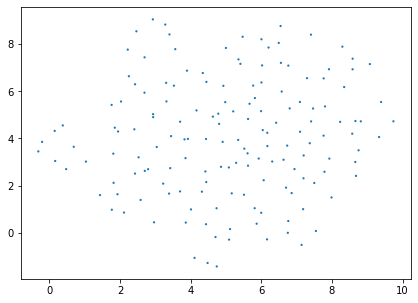

In [137]:
import umap

X_topics = svd_model.fit_transform(X)
print(X_topics)
embedding = umap.UMAP(n_neighbors=10, min_dist=1, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
# c = de_tweets['user_city'],
s = 5, # size
edgecolor='none'
)
plt.show()